# Setup

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import efficientnet_v2_s
from torch.utils.data import DataLoader
from tqdm import tqdm
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score

device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

# Dataloader

In [2]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# Custom Dataset for Screen Grading
class ScreenDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None):
        """
        Args:
            csv_file (str): Path to the CSV file with session IDs and grades.
            image_dir (str): Directory containing session ID folders with images.
            transform (callable, optional): Transform to apply on images.
        """
        self.data = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get session_id and grade
        session_id = self.data.iloc[idx]['session_id']
        screen_grade = self.data.iloc[idx]['qc_screen_grading']  # Adjust column name as needed

        # Locate the folder and the front image
        folder_path = os.path.join(self.image_dir, session_id)
        front_image_path = [img for img in os.listdir(folder_path) if "INPUT_FRONT" in img][0]
        image_path = os.path.join(folder_path, front_image_path)

        # Load and process the image
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        # Map screen_grade to integer labels (e.g., {'A1': 0, 'A2': 1, 'A3': 2, 'C1': 3, 'R2': 4})
        label_mapping = {'A1': 0, 'A2': 1, 'A3': 2, 'C1': 3, 'R2': 4}
        label = label_mapping[screen_grade]

        return image, label

In [34]:
import torchvision.transforms.functional as F
from PIL import Image

class LetterBoxResize:
    def __init__(self, target_size):
        """
        Initializes the letterbox resize transformation.
        Args:
            target_size (tuple): Target size as (width, height).
        """
        self.target_size = target_size

    def __call__(self, img):
        """
        Applies letterbox resizing to the input image.
        Args:
            img (PIL.Image): Input image.
        Returns:
            PIL.Image: Image with letterbox resizing applied.
        """
        # Get the original dimensions
        original_width, original_height = img.size
        target_width, target_height = self.target_size

        # Calculate scale and new dimensions
        scale = min(target_width / original_width, target_height / original_height)
        new_width = int(original_width * scale)
        new_height = int(original_height * scale)

        # Resize the image
        img = img.resize((new_width, new_height), Image.Resampling.BILINEAR)

        # Create a new blank (black) image with the target size
        new_img = Image.new("RGB", (target_width, target_height), (0, 0, 0))

        # Paste the resized image onto the blank canvas
        paste_x = (target_width - new_width) // 2
        paste_y = (target_height - new_height) // 2
        new_img.paste(img, (paste_x, paste_y))

        return new_img

In [ ]:
import torchvision.transforms as transforms

# Updated Transformations
# transform = transforms.Compose([
#     transforms.Resize((1280, 640)),  # Maintain original resolution
#     transforms.RandomRotation(degrees=(-5, 5)),  # Minimal rotation
#     transforms.RandomApply([
#         transforms.ColorJitter(brightness=0.1, contrast=0.1)  # Subtle brightness/contrast adjustments
#     ], p=0.3),  # Apply only 30% of the time
#     transforms.RandomResizedCrop(size=(1280, 640), scale=(0.8, 1.0)),  # Slight zoom-in
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Standard normalization
# ])

# Define transformations with LetterBoxResize
transform = transforms.Compose([
    LetterBoxResize((640,1280)),  # Resize to 640x1280 while maintaining aspect ratio
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Standard normalization
])

# Dataset and Dataloader paths
csv_file_path = '/Users/sabainaharoon/Documents/compasia/ai_grading/grading_system/data/cleaned_file_14thjan_dbdata_datefix.csv'
image_dir = '/Users/sabainaharoon/Documents/compasia/ai_grading/grading_system/testing_grading_accuracy/organized_cleaned_images'

# Create dataset
dataset = ScreenDataset(csv_file=csv_file_path, image_dir=image_dir, transform=transform)

# Split data (use stratified sampling if possible)
train_size = int(0.87 * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_set, batch_size=4, shuffle=True)  # Smaller batch size for limited data
test_loader = DataLoader(test_set, batch_size=4, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6051416].


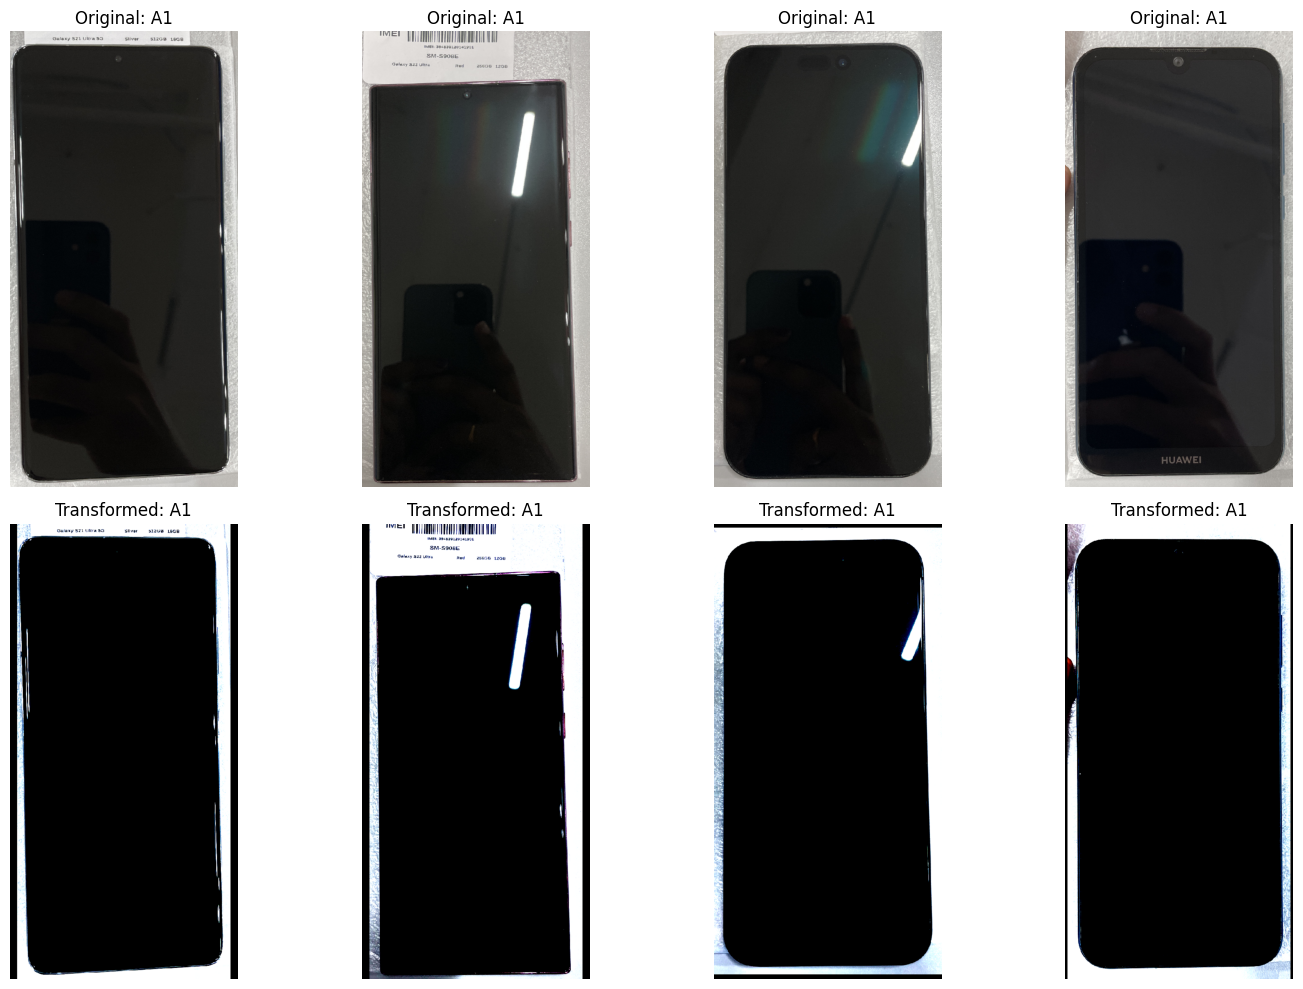

In [43]:
import matplotlib.pyplot as plt
import random

# Function to display a batch of images
def show_images(original_images, transformed_images, labels, classes):
    fig, axes = plt.subplots(2, len(transformed_images), figsize=(15, 10))
    for i, (orig_img, trans_img, label) in enumerate(zip(original_images, transformed_images, labels)):
        axes[0, i].imshow(orig_img.permute(1, 2, 0).cpu().numpy())
        axes[0, i].set_title(f"Original: {classes[label]}")
        axes[0, i].axis('off')
        
        axes[1, i].imshow(trans_img.permute(1, 2, 0).cpu().numpy())
        axes[1, i].set_title(f"Transformed: {classes[label]}")
        axes[1, i].axis('off')
    plt.tight_layout()
    plt.show()

# Shuffle the dataset and get a random batch
def get_random_batch(loader, dataset, image_dir, transform):
    # Randomize indices for new samples
    indices = random.sample(range(len(dataset)), loader.batch_size)
    images, labels = [], []
    original_images = []
    
    for idx in indices:
        # Get label
        label = dataset.data.iloc[idx]['qc_screen_grading']
        labels.append(label)
        
        # Get transformed image
        transformed_image, _ = dataset[idx]
        images.append(transformed_image)

        # Get original image path
        session_id = dataset.data.iloc[idx]['session_id']
        folder_path = os.path.join(image_dir, session_id)
        front_image_path = [img for img in os.listdir(folder_path) if "INPUT_FRONT" in img][0]
        image_path = os.path.join(folder_path, front_image_path)

        # Load original image
        original_image = Image.open(image_path).convert("RGB")
        original_image = resize_transform(original_image)  # Resize to the same dimensions
        original_images.append(transforms.ToTensor()(original_image))
    
    # Convert to tensors
    images = torch.stack(images)
    original_images = torch.stack(original_images)
    labels = [class_names.index(label) for label in labels]

    return original_images, images, torch.tensor(labels)

# Define class names
class_names = ['A1', 'A2', 'A3', 'C1', 'R2']

# Get a random batch of images
resize_transform = transforms.Resize((1280, 640))  # Resize for original images
original_images, transformed_images, labels = get_random_batch(train_loader, dataset, image_dir, transform=transform)

# Display the images
show_images(original_images, transformed_images, labels, class_names)

# Experimentations

## Effecient net model

In [44]:
# Define EfficientNetV2 model
def get_efficientnet_model(num_classes=5):
    model = efficientnet_v2_s(pretrained=True)  # Pretrained EfficientNetV2-Small
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)  # Adjust for 5 classes
    return model

model = get_efficientnet_model(num_classes=5).to(device)

/Users/sabainaharoon/env_cma/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/sabainaharoon/env_cma/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /Users/sabainaharoon/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:16<00:00, 5.30MB/s]


# DATAloader class imbalanced way

In [47]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Custom Dataset for Screen Grading
class ScreenDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None):
        """
        Args:
            csv_file (str): Path to the CSV file with session IDs and grades.
            image_dir (str): Directory containing session ID folders with images.
            transform (callable, optional): Transform to apply on images.
        """
        self.data = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        session_id = self.data.iloc[idx]['session_id']
        screen_grade = self.data.iloc[idx]['qc_screen_grading']  # Adjust column name if needed

        # Locate the folder and the front image
        folder_path = os.path.join(self.image_dir, session_id)
        front_image_path = [img for img in os.listdir(folder_path) if "INPUT_FRONT" in img][0]
        image_path = os.path.join(folder_path, front_image_path)

        # Load and process the image
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        # Map screen_grade to integer labels (e.g., {'A1': 0, 'A2': 1, 'A3': 2, 'C1': 3, 'R2': 4})
        label_mapping = {'A1': 0, 'A2': 1, 'A3': 2, 'C1': 3, 'R2': 4}
        label = label_mapping[screen_grade]

        return image, label


# Custom letterbox resize transform
class LetterBoxResize:
    def __init__(self, target_size):
        self.target_size = target_size

    def __call__(self, img):
        original_width, original_height = img.size
        target_width, target_height = self.target_size
        scale = min(target_width / original_width, target_height / original_height)
        new_width = int(original_width * scale)
        new_height = int(original_height * scale)
        img = img.resize((new_width, new_height), Image.Resampling.BILINEAR)
        new_img = Image.new("RGB", (target_width, target_height), (0, 0, 0))
        paste_x = (target_width - new_width) // 2
        paste_y = (target_height - new_height) // 2
        new_img.paste(img, (paste_x, paste_y))
        return new_img


# Define transformations
transform = transforms.Compose([
    LetterBoxResize((640, 1280)),
    transforms.RandomHorizontalFlip(p=0.5),  # Augmentation
    transforms.RandomRotation(10),  # Augmentation
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


# Create dataset
dataset = ScreenDataset(csv_file=csv_file_path, image_dir=image_dir, transform=transform)

# Compute class weights for WeightedRandomSampler
class_labels = dataset.data['qc_screen_grading'].astype(str)  # Ensure all labels are strings
class_weights = compute_class_weight('balanced', classes=np.unique(class_labels), y=class_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float)

# Create WeightedRandomSampler
label_to_weight = {label: weight for label, weight in zip(np.unique(class_labels), class_weights)}
sample_weights = class_labels.map(label_to_weight).values.astype(np.float32)
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# DataLoader
train_loader = DataLoader(dataset, batch_size=8, sampler=sampler)
test_loader = DataLoader(dataset, batch_size=8, shuffle=False)

### Training Loop

In [45]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{epochs}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader):.4f}")

    # Evaluate on test set
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    test_acc = accuracy_score(all_labels, all_preds)
    print(f"Test Accuracy: {test_acc * 100:.2f}%")

Training Epoch 1/10:   0%|          | 0/25 [00:44<?, ?it/s]


KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..1.5593902].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9637812..1.9602616].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..1.733682].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.343704].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clippi

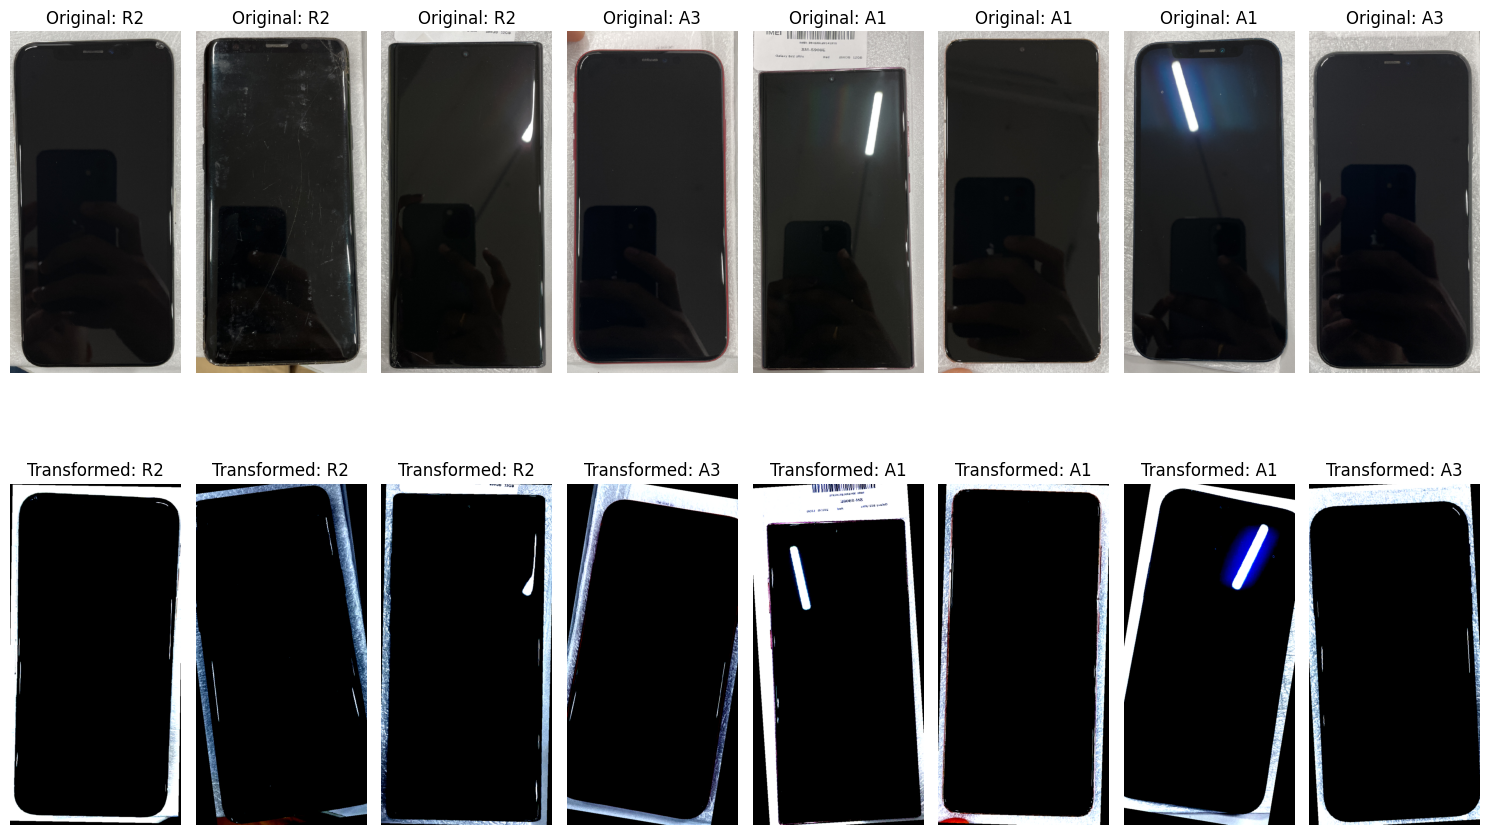

In [48]:
import matplotlib.pyplot as plt
import random

# Function to display a batch of images
def show_images(original_images, transformed_images, labels, classes):
    fig, axes = plt.subplots(2, len(transformed_images), figsize=(15, 10))
    for i, (orig_img, trans_img, label) in enumerate(zip(original_images, transformed_images, labels)):
        axes[0, i].imshow(orig_img.permute(1, 2, 0).cpu().numpy())
        axes[0, i].set_title(f"Original: {classes[label]}")
        axes[0, i].axis('off')

        axes[1, i].imshow(trans_img.permute(1, 2, 0).cpu().numpy())
        axes[1, i].set_title(f"Transformed: {classes[label]}")
        axes[1, i].axis('off')
    plt.tight_layout()
    plt.show()

# Shuffle the dataset and get a random batch
def get_random_batch(loader, dataset, image_dir, transform):
    # Randomize indices for new samples
    indices = random.sample(range(len(dataset)), loader.batch_size)
    images, labels = [], []
    original_images = []

    for idx in indices:
        # Get label
        label = dataset.data.iloc[idx]['qc_screen_grading']
        labels.append(label)

        # Get transformed image
        transformed_image, _ = dataset[idx]
        images.append(transformed_image)

        # Get original image path
        session_id = dataset.data.iloc[idx]['session_id']
        folder_path = os.path.join(image_dir, session_id)
        front_image_path = [img for img in os.listdir(folder_path) if "INPUT_FRONT" in img][0]
        image_path = os.path.join(folder_path, front_image_path)

        # Load original image
        original_image = Image.open(image_path).convert("RGB")
        original_image = resize_transform(original_image)  # Resize to the same dimensions
        original_images.append(transforms.ToTensor()(original_image))

    # Convert to tensors
    images = torch.stack(images)
    original_images = torch.stack(original_images)
    labels = [class_names.index(label) for label in labels]

    return original_images, images, torch.tensor(labels)

# Define class names
class_names = ['A1', 'A2', 'A3', 'C1', 'R2']

# Get a random batch of images
resize_transform = transforms.Resize((1280, 640))  # Resize for original images
original_images, transformed_images, labels = get_random_batch(train_loader, dataset, image_dir, transform=transform)

# Display the images
show_images(original_images, transformed_images, labels, class_names)

### Result analysis

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=['A1', 'A2', 'A3', 'C1', 'R2']))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['A1', 'A2', 'A3', 'C1', 'R2'], yticklabels=['A1', 'A2', 'A3', 'C1', 'R2'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Training loop class imabalance

In [49]:
import torch
import torch.nn as nn
from torchvision.models import efficientnet_v2_s
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# Define EfficientNetV2 model
def get_efficientnet_model(num_classes=5):
    model = efficientnet_v2_s(pretrained=True)  # Pretrained EfficientNetV2-Small
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)  # Adjust for 5 classes
    return model

# Initialize model, loss function, optimizer, and scheduler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_efficientnet_model(num_classes=5).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))  # Use weighted loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


/Users/sabainaharoon/env_cma/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/sabainaharoon/env_cma/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Initialize lists to store losses and accuracies
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# Training loop
epochs = 10
best_acc = 0.0

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training phase
    for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{epochs}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Compute training accuracy
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    print(f"Epoch {epoch+1}, Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc * 100:.2f}%")

    # Evaluation phase
    model.eval()
    test_running_loss = 0.0
    correct_test = 0
    total_test = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_running_loss += loss.item()

            # Compute testing accuracy
            _, preds = torch.max(outputs, 1)
            correct_test += (preds == labels).sum().item()
            total_test += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss = test_running_loss / len(test_loader)
    test_acc = correct_test / total_test
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    print(f"Epoch {epoch+1}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc * 100:.2f}%")

    # Save the best model
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"Saved Best Model at Epoch {epoch+1}")

    # Step the scheduler
    scheduler.step()

Training Epoch 1/10:   0%|          | 0/15 [00:00<?, ?it/s]